In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import os

from torch import nn, optim
from torch.optim import lr_scheduler
import time
import SOM

In [2]:
def sigma68(data): return 0.5*(pd.Series(data).quantile(q = 0.84) - pd.Series(data).quantile(q = 0.16))

In [3]:
def exposure_SN(cat_in, filters,  scale = True):

    sn_lims =  {'U': 25.25, 'G': 24.65, 'R': 24.15, 'I': 24.35, 'ZN': 23.95,  'H':25,'J':25, 'Y':25}

    scale_filters = [x for x in filters if scale == True]
    lims = [sn_lims[x] for x in filters]

    sn_val0 = 5
    R = 1

    sn_val = [(R*sn_val0 if x in scale_filters else sn_val0) for x in filters]

    D = sn_val*10**(np.array(lims) / 5.)

    mag = np.array(cat_in[[x for x in filters]])
    SN_arr =  D*10**(-0.2*mag)


    sn_min = 0
    sn_max = lims


    SN_arr = np.clip(SN_arr, sn_min, sn_max)
    SN = pd.DataFrame(SN_arr, columns=filters, index= cat_in.index)

    return SN



In [4]:
catalog = pd.read_csv('/data/astro/scratch/lcabayol/Euclid/PAUS_mock_Euclidbands.csv', sep = ',', header = 0, comment = '#')
catalog = catalog.sample(40000)
catalog = catalog.dropna()

catalog['ref_id'] = np.arange(len(catalog))

nb_names_old = ['flux_nl_el_t_pau_nb%s'%x for x in 455+10*np.arange(40)]
nb_names_new = ['NB%s'%x for x in 455+10*np.arange(40)]
nb_name_dict = dict(zip(nb_names_old, nb_names_new))

catalog_nb_nl = catalog.set_index('ref_id')[nb_names_old].rename(columns = nb_name_dict)

bb_names_old = ['flux_nl_el_t_cfht_u','flux_nl_el_t_blanco_decam_g','flux_nl_el_t_blanco_decam_r','flux_nl_el_t_blanco_decam_i','flux_nl_el_t_blanco_decam_z','flux_nl_el_t_euclid_nisp_h','flux_nl_el_t_euclid_nisp_j','flux_nl_el_t_euclid_nisp_y']
bb_names_new = ['U','G','R','I','ZN','H','J','Y']
bb_name_dict = dict(zip(bb_names_old, bb_names_new))

catalog_bb_nl = catalog.set_index('ref_id')[bb_names_old].rename(columns = bb_name_dict)


In [7]:
# load fits from Martin Eriksen to estimate SNR from the flux

snr_fit = pd.read_csv('/nfs/pic.es/user/l/lcabayol/Euclid/snr_fit.csv', sep = ',', header = 0)
factors = snr_fit[snr_fit.key == 'med'].reset_index()

aas = factors.a.values
bs = factors.b.values

f = 0.7
SNR_NB = np.exp(aas*np.log(f*np.abs(catalog_nb_nl.values)) + bs)
err = (np.abs(catalog_nb_nl.values) / SNR_NB)  * np.random.normal(0,1, size = (catalog_nb_nl.shape))

catalog_nb = pd.DataFrame(catalog_nb_nl + err, columns = nb_names_new, index = catalog_nb_nl.index)
catalog_nb_err = pd.DataFrame(np.abs(err), columns = nb_names_new, index = catalog_nb_nl.index)

In [8]:
catalog_bb_nl_mag = 26 - 2.5*np.log10(catalog_bb_nl)
filters = bb_names_new.copy()

SNR_flagship_BB = exposure_SN(catalog_bb_nl_mag, filters,  scale = True)

err = np.abs(catalog_bb_nl / SNR_flagship_BB)
err_rand = err * np.random.normal(0,1, size = (err.shape))

catalog_bb = catalog_bb_nl.values + err_rand
catalog_bb_err = np.abs(err_rand)

catalog_bb = pd.DataFrame(catalog_bb, columns = bb_names_new, index = catalog_bb_nl.index)
catalog_bb_err = pd.DataFrame(np.abs(err), columns = bb_names_new, index = catalog_bb_nl.index)


In [9]:
catalog_bb = 26 - 2.5*np.log10(catalog_bb)
catalog_bb['target_zs'] = catalog.observed_redshift_gal.values
m = np.arange(18,24,1)
s68 = [0.0025,0.003,0.004,0.0045,0.0055,0.007]
fSNR  = np.polyfit(m,s68,2)
imag = catalog_bb.I.values

dispersion_z = fSNR[0] * imag**2 + fSNR[1]*imag  + fSNR[2]
photoz = catalog_bb.target_zs.values+  dispersion_z * np.random.normal(0,1,size = catalog_bb.shape[0])
catalog_bb['target_zb'] = photoz

#catalog_bb['target_train'] = catalog_bb.target_zs
mask_train = np.random.choice([0,1], p = [0.7,0.3], size = len(catalog_bb))
target_train = catalog_bb.target_zs * mask_train
target_train = np.where(target_train== 0,catalog_bb.target_zb,catalog_bb.target_zs)
catalog_bb['true_z'] = catalog_bb.target_zs
catalog_bb['target_zs'] = catalog_bb.target_zs * mask_train
catalog_bb['target_zb'] = target_train


In [10]:
catalog_bb = catalog_bb.dropna()

## train SOM on the full catalogue

In [11]:
nx, ny = 40,40
epochs = 100000

In [12]:
selforgmap = SOM.SOM(x = nx, y = ny, epochs = epochs, vec_size = 7, metric = 'Euclidean',lr0 = 0.01, sigma0 = 5, initialisation = 'RandomNormal')


In [13]:
training_sample = catalog_bb[['U','G','R','I','ZN','H','J','Y']].values
training_sample = training_sample[:,:-1] - training_sample[:,1:]

In [14]:
selforgmap.train(training_sample, samples_epoch = 1)

In [15]:
bmus = []
for k in range(len(training_sample)-1):
    bmu = selforgmap.test_obj(training_sample[k:(k+1)])
    bmus.append(bmu)
bmu = selforgmap.test_obj(training_sample[(k+1):])
bmus.append(bmu)

In [16]:
catalog_bb['bmu'] = np.array(bmus)

In [17]:
x_cells = np.arange(0,nx)
y_cells = np.arange(0,ny)
index_cell = np.arange(nx*ny)
cells = np.array(np.meshgrid(x_cells,y_cells)).T.reshape(-1,2)
cells = pd.DataFrame(np.c_[cells[:,0],cells[:,1],index_cell], columns = ['x_cell','y_cell','bmu'])


catalog_bb =catalog_bb.drop_duplicates()

In [18]:
catalog_bb = catalog_bb.merge(cells, on = 'bmu')
som_vis = catalog_bb.groupby('bmu').target_zb.median().reset_index()
som_vis = som_vis.merge(cells, on = 'bmu')
som_data = som_vis.pivot(index = 'x_cell', columns = 'y_cell', values = 'target_zb')

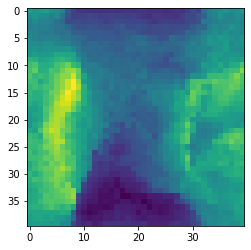

In [19]:
plt.imshow(som_data)

## add missing colour space regions

In [20]:
from sqlalchemy.engine import create_engine
from sqlalchemy import *
from sqlalchemy.orm import *

engine = create_engine('postgresql://readonly@db03.pau.pic.es/dm')

query = f"""
    SELECT cm.paudm_id, cm.zspec, cm."I_auto", cm.ra, cm.dec, cm.conf, cm."Umag", cm."Bmag", cm."Vmag", cm."Rmag", cm."ICmag", cm."Zmag"
    FROM COSMOS as cm
    """

with engine.begin() as conn:
    conn.execute("SET TRANSACTION ISOLATION LEVEL SERIALIZABLE READ ONLY DEFERRABLE")
    ilbert = pd.read_sql(query, conn)


In [196]:
bmu_to_drop = cells[(cells.x_cell > 10)&(cells.x_cell < 25)&(cells.y_cell > 35)&(cells.y_cell <40)].bmu.values


In [197]:
catalog_bb["mask_train"] = np.where(catalog_bb.bmu.isin(bmu_to_drop),0, 1)

In [198]:
mask_train = np.random.choice([0,1], p = [0.7,0.3], size = len(catalog_bb))

In [199]:
catalog_bb["mask_train"] = catalog_bb.mask_train * mask_train

In [200]:
catalog_bb_zs = catalog_bb[catalog_bb.mask_train != 0]

In [201]:
som_vis = catalog_bb_zs.groupby('bmu').target_zb.median().reset_index()
som_vis = som_vis.merge(cells, on = 'bmu')
som_data = som_vis.pivot(index = 'x_cell', columns = 'y_cell', values = 'target_zb')

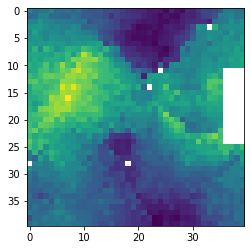

In [202]:
plt.imshow(som_data)

In [203]:
catalog_bb['target_zs'] = catalog_bb.true_z.values

In [204]:
m = np.arange(18,24,1)
s68 = [0.0025,0.003,0.004,0.0045,0.0055,0.007]
fSNR  = np.polyfit(m,s68,2)
imag = catalog_bb.I.values

dispersion_z = fSNR[0] * imag**2 + fSNR[1]*imag  + fSNR[2]
photoz = catalog_bb.target_zs.values +  dispersion_z * np.random.normal(0,1,size = catalog_bb.shape[0])
catalog_bb['target_zb'] = photoz

In [205]:
photoz

array([0.42585864, 0.29582788, 0.43239744, ..., 0.69472395, 0.65729886,
       0.7661341 ])

In [206]:
target_train = catalog_bb.target_zs * catalog_bb.mask_train
target_train = np.where(target_train== 0,catalog_bb.target_zb,catalog_bb.target_zs)
catalog_bb['target_zs'] = catalog_bb.target_zs * mask_train
catalog_bb['target_zb'] = target_train


## TRAIN NETWORKS

### BB

In [207]:
import MTLphotozs

In [208]:
catalog_bb_sub = catalog_bb[catalog_bb.target_zs != 0]#.reset_index()
catalog_nb_sub = catalog_nb[catalog_nb.index.isin(catalog_bb_sub.index)]
catalog_nb_sub = 26-2.5*np.log10(catalog_nb_sub)

In [209]:
BB = MTLphotozs.mtl_photoz(zs = True, flagship=True)
catalog_training= catalog_bb_sub.copy()
catalog_nb_train = catalog_nb_sub[catalog_nb_sub.index.isin(catalog_training.index)]

training_loader = BB.create_loader(catalog_training,catalog_nb_train)
BBnet = BB.train_mtl(training_loader, epochs = 65)

### BB + NB

In [210]:
catalog_bb_sub = catalog_bb[catalog_bb.target_zb != 0].reset_index()
catalog_nb_sub = catalog_nb[catalog_nb.index.isin(catalog_bb_sub.index)]
catalog_nb_sub = 26-2.5*np.log10(catalog_nb_sub)

In [211]:
BBNB = MTLphotozs.mtl_photoz(zs = False, zs_NB = True, flagship = True)
catalog_training= catalog_bb_sub.copy()
catalog_nb_train = catalog_nb_sub[catalog_nb_sub.index.isin(catalog_training.index)]

training_loader = BBNB.create_loader(catalog_training,catalog_nb_train)
BBNBnet = BBNB.train_mtl(training_loader, epochs = 65)

### BB + z

In [212]:
catalog_bb_sub = catalog_bb[catalog_bb.target_zb != 0].reset_index()
catalog_nb_sub = catalog_nb[catalog_nb.index.isin(catalog_bb_sub.index)]
catalog_nb_sub = 26-2.5*np.log10(catalog_nb_sub)

In [213]:
BBz = MTLphotozs.mtl_photoz(zs = False, zs_zb = True, flagship = True)
catalog_training= catalog_bb_sub.copy()
catalog_nb_train = catalog_nb_sub[catalog_nb_sub.index.isin(catalog_training.index)]

training_loader = BBz.create_loader(catalog_training,catalog_nb_train)
BBznet = BBz.train_mtl(training_loader, epochs = 65)

## BB + NB + z

In [214]:
catalog_bb_sub = catalog_bb[catalog_bb.target_zb != 0].reset_index()
catalog_nb_sub = catalog_nb[catalog_nb.index.isin(catalog_bb_sub.index)]
catalog_nb_sub = 26-2.5*np.log10(catalog_nb_sub)

In [215]:
BBNBz = MTLphotozs.mtl_photoz(zs = False, zs_NB_zb = True, flagship = True)
catalog_training= catalog_bb_sub.copy()
catalog_nb_train = catalog_nb_sub[catalog_nb_sub.index.isin(catalog_training.index)]

training_loader = BBNBz.create_loader(catalog_training,catalog_nb_train)
BBNBznet = BBNBz.train_mtl(training_loader, epochs = 65)

## TEST TO i<25

In [216]:
catalog_test = pd.read_csv('/data/astro/scratch/lcabayol/Euclid/Euclid_mock_v2.csv', sep = ',', header = 0, comment = '#')
catalog_test = catalog_test.dropna()
catalog_test = catalog_test[catalog_test.observed_redshift_gal < 1.5]

catalog_test['mag'] =  -2.5 * np.log10(catalog_test.blanco_decam_i) - 48.6
catalog_test = catalog_test[catalog_test.mag < 25]
catalog_test = catalog_test[catalog_test.mag > 18]
catalog_test = catalog_test.sample(50000)
catalog_test = catalog_test.reset_index()

In [217]:
BB_name = ['cfis_u','blanco_decam_g','blanco_decam_r','blanco_decam_i','blanco_decam_z','euclid_nisp_h','euclid_nisp_j','euclid_nisp_y']
catalog_bb_test = catalog_test[BB_name]
bb_names_new = ['U','G','R','I','ZN','H','J','Y']
bb_name_dict = dict(zip(BB_name, bb_names_new))

catalog_bb_test_nl = catalog_bb_test.rename(columns = bb_name_dict)
catalog_bb_test_nl_mag = -48.6 - 2.5*np.log10(catalog_bb_test_nl)
filters = bb_names_new.copy()

SNR_flagship_BB = exposure_SN(catalog_bb_test_nl_mag, filters,  scale = True)
err = np.abs(catalog_bb_test_nl / SNR_flagship_BB)
err_rand = err * np.random.normal(0,1, size = (err.shape))

catalog_bb_test = catalog_bb_test_nl.values + err_rand.values

catalog_bb_test = pd.DataFrame(catalog_bb_test, columns = bb_names_new)

samps_BB_spec_test_store = catalog_bb_test.copy()

samps_BB_spec_test = catalog_bb_test[bb_names_new].values
samps_BB_spec_test = -2.5 * np.log10(samps_BB_spec_test) - 48.6

zspec_test = catalog_test.observed_redshift_gal.values
zb_bin_spec_test = 1000* zspec_test

colors_spec_test = samps_BB_spec_test[:,:-1] - samps_BB_spec_test[:,1:] 

colors_spec_test, zspec_test, zb_bin_spec_test = torch.Tensor(colors_spec_test), torch.Tensor(zspec_test), torch.LongTensor(zb_bin_spec_test)
mag_test = -2.5 * np.log10(catalog_bb_test.I) - 48.6


/tmp/ipykernel_55/2075870673.py:21: RuntimeWarning: invalid value encountered in log10
  samps_BB_spec_test = -2.5 * np.log10(samps_BB_spec_test) - 48.6


In [218]:
BBnet = BBnet.eval()
_, logalphas, z,logzerr = BBnet(colors_spec_test.cuda())
alphas = torch.exp(logalphas)
zb = (alphas * z).sum(1)
zb,logzerr  = zb.detach().cpu().numpy(), logzerr.detach().cpu().numpy()

df_bb = pd.DataFrame(np.c_[zb,zspec_test,mag_test], columns = ['zb_bb','zb_true','imag'])
df_bb['rerr_bb'] = (df_bb.zb_bb - df_bb.zb_true) / (1 + df_bb.zb_true)
print('Bias',np.nanmedian(df_bb.rerr_bb), 'scatter', sigma68(df_bb.rerr_bb))


Bias -0.026113589017789714 scatter 0.0839060300096442


In [219]:
BBNBnet = BBNBnet.eval()
_, logalphas, z,logzerr = BBNBnet(colors_spec_test.cuda()) 
alphas = torch.exp(logalphas)
zb = (alphas * z).sum(1)
zb,logzerr  = zb.detach().cpu().numpy(), logzerr.detach().cpu().numpy()

df_bbnb = pd.DataFrame(np.c_[zb,zspec_test,mag_test], columns = ['zb_bbnb','zb_true','imag'])
df_bbnb['rerr_bbnb'] = (df_bbnb.zb_bbnb - df_bbnb.zb_true) / (1 + df_bbnb.zb_true)
print('Bias',np.nanmedian(df_bbnb.rerr_bbnb), 'scatter', sigma68(df_bbnb.rerr_bbnb))


Bias -0.013756094557717233 scatter 0.08170200543610531


In [220]:
BBznet = BBznet.eval()
_, logalphas, z,logzerr = BBznet(colors_spec_test.cuda()) 
alphas = torch.exp(logalphas)
zb = (alphas * z).sum(1)
zb,logzerr  = zb.detach().cpu().numpy(), logzerr.detach().cpu().numpy()

df_bbz = pd.DataFrame(np.c_[zb,zspec_test,mag_test], columns = ['zb_bbz','zb_true','imag'])
df_bbz['rerr_bbz'] = (df_bbz.zb_bbz - df_bbz.zb_true) / (1 + df_bbz.zb_true)
print('Bias',np.nanmedian(df_bbz.rerr_bbz), 'scatter', sigma68(df_bbz.rerr_bbz))


Bias -0.016655611424188234 scatter 0.07845537726902894


In [221]:
BBNBznet = BBNBznet.eval()
_, logalphas, z,logzerr = BBNBznet(colors_spec_test.cuda()) 
alphas = torch.exp(logalphas)
zb = (alphas * z).sum(1)
zb,logzerr  = zb.detach().cpu().numpy(), logzerr.detach().cpu().numpy()

df_bbnbz = pd.DataFrame(np.c_[zb,zspec_test,mag_test], columns = ['zb_bbnbz','zb_true','imag'])
df_bbnbz['rerr_bbnbz'] = (df_bbnbz.zb_bbnbz - df_bbnbz.zb_true) / (1 + df_bbnbz.zb_true)
print('Bias',np.nanmedian(df_bbnbz.rerr_bbnbz), 'scatter', sigma68(df_bbnbz.rerr_bbnbz))


Bias -0.018175435193315888 scatter 0.07916176311491355


In [222]:
df_bb

,zb_bb,zb_true,imag,rerr_bb
0,0.582471,0.604271,21.039641,-0.013589
1,0.602772,0.521043,24.934057,0.053733
2,0.327030,0.334584,20.950330,-0.005660
3,0.957835,0.767161,23.848143,0.107899
4,0.863718,1.079127,22.769616,-0.103605
...,...,...,...,...
49995,1.191513,1.282756,23.853770,-0.039971
49996,0.428452,0.332815,21.774633,0.071756
49997,0.601948,0.414968,23.583569,0.132144
49998,1.121517,1.325267,24.206573,-0.087624


In [223]:
df = df_bb.reset_index().merge(df_bbnb[['zb_bbnb','rerr_bbnb']].reset_index(), on = 'index')
df = df.merge(df_bbz[['zb_bbz','rerr_bbz']].reset_index(), on = 'index')
df = df.merge(df_bbnbz[['zb_bbnbz','rerr_bbnbz']].reset_index(), on = 'index')

In [150]:
df

,index,zb_bb,zb_true,imag,rerr_bb,zb_bbnb,rerr_bbnb,zb_bbz,rerr_bbz,zb_bbnbz,rerr_bbnbz
0,0,0.800118,0.713547,23.556600,0.050522,0.769365,0.032575,0.769617,0.032722,0.774210,0.035402
1,1,0.556525,0.336803,24.857080,0.164364,0.499685,0.121845,0.564727,0.170499,0.728773,0.293215
2,2,1.052051,1.165612,23.105047,-0.052439,1.071965,-0.043243,1.087795,-0.035933,1.071127,-0.043630
3,3,0.226300,0.334477,23.362350,-0.081064,0.210945,-0.092570,0.218657,-0.086790,0.206059,-0.096231
4,4,0.950886,1.467650,24.051142,-0.209416,1.231437,-0.095724,1.480692,0.005285,1.488136,0.008302
...,...,...,...,...,...,...,...,...,...,...,...
49995,49995,0.696691,0.830941,24.181551,-0.073323,0.737589,-0.050986,0.728028,-0.056208,0.781229,-0.027151
49996,49996,1.296587,1.177190,24.145733,0.054840,1.305034,0.058720,1.243750,0.030572,1.264142,0.039938
49997,49997,0.800625,1.342604,24.151377,-0.231357,0.831107,-0.218345,0.974824,-0.156996,0.968944,-0.159506
49998,49998,0.448537,0.563336,24.698695,-0.073432,0.440028,-0.078875,0.472959,-0.057810,0.477657,-0.054805


In [224]:
#colors_spec_test = colors_spec_test.detach().cpu().numpy()
bmus = []
for k in range(len(colors_spec_test)-1):
    bmu = selforgmap.test_obj(colors_spec_test[k:(k+1)])
    bmus.append(bmu)
bmu = selforgmap.test_obj(colors_spec_test[(k+1):])
bmus.append(bmu)

In [225]:
df['bmu'] = np.array(bmus)

df = df.merge(cells, on = 'bmu')

In [226]:
df_sub = df[df.imag < 23]

In [228]:
som_vis_bb = df.groupby('bmu').rerr_bb.apply(sigma68).reset_index()
som_vis_bb = som_vis_bb.merge(cells, on = 'bmu')
som_data_bb = som_vis_bb.pivot(index = 'x_cell', columns = 'y_cell', values = 'rerr_bb')

som_vis_bbnb = df.groupby('bmu').rerr_bbnb.apply(sigma68).reset_index()
som_vis_bbnb = som_vis_bbnb.merge(cells, on = 'bmu')
som_data_bbnb = som_vis_bbnb.pivot(index = 'x_cell', columns = 'y_cell', values = 'rerr_bbnb')

som_vis_bbz = df.groupby('bmu').rerr_bbz.apply(sigma68).reset_index()
som_vis_bbz = som_vis_bbz.merge(cells, on = 'bmu')
som_data_bbz = som_vis_bbz.pivot(index = 'x_cell', columns = 'y_cell', values = 'rerr_bbz')

som_vis_bbnbz = df.groupby('bmu').rerr_bbnbz.apply(sigma68).reset_index()
som_vis_bbnbz = som_vis_bbnbz.merge(cells, on = 'bmu')
som_data_bbnbz = som_vis_bbnbz.pivot(index = 'x_cell', columns = 'y_cell', values = 'rerr_bbnbz')



In [193]:
som_vis_bb = df.groupby('bmu').zb_true.median().reset_index()
som_vis_bb = som_vis_bb.merge(cells, on = 'bmu')
som_data_bb = som_vis_bb.pivot(index = 'x_cell', columns = 'y_cell', values = 'zb_true')

som_vis_bbnb = df.groupby('bmu').rerr_bbnb.median().reset_index()
som_vis_bbnb = som_vis_bbnb.merge(cells, on = 'bmu')
som_data_bbnb = som_vis_bbnb.pivot(index = 'x_cell', columns = 'y_cell', values = 'rerr_bbnb')

som_vis_bbz = df.groupby('bmu').rerr_bbz.median().reset_index()
som_vis_bbz = som_vis_bbz.merge(cells, on = 'bmu')
som_data_bbz = som_vis_bbz.pivot(index = 'x_cell', columns = 'y_cell', values = 'rerr_bbz')

som_vis_bbnbz = df.groupby('bmu').rerr_bbnbz.median().reset_index()
som_vis_bbnbz = som_vis_bbnbz.merge(cells, on = 'bmu')
som_data_bbnbz = som_vis_bbnbz.pivot(index = 'x_cell', columns = 'y_cell', values = 'rerr_bbnbz')



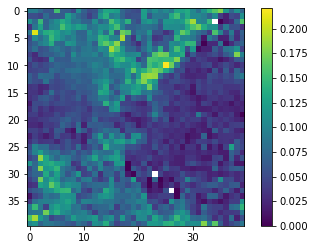

In [229]:
plt.imshow(som_data_bbnbz)
plt.colorbar()

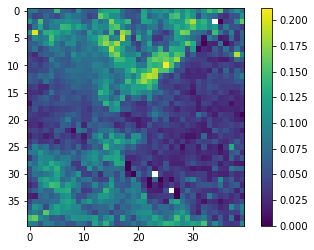

In [230]:
plt.imshow(som_data_bbz)
plt.colorbar()

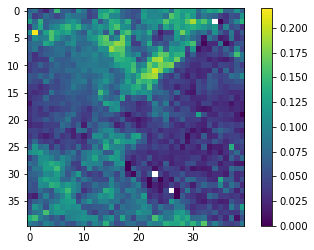

In [231]:
plt.imshow(som_data_bb)
plt.colorbar()

In [ ]:
## conclusion: different colourspace regions could correcpond tothe same type of galaxies.